## Forecast the Airlines Passengers data set. Prepare a document for each model explaining 
## how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
##Forecasting.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving Airlines+Data.xlsx to Airlines+Data.xlsx


In [3]:
df = pd.read_excel("Airlines+Data.xlsx")

In [4]:
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [6]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


# Visualization

<AxesSubplot:>

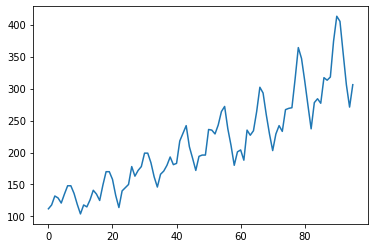

In [7]:
df.Passengers.plot()

<AxesSubplot:>

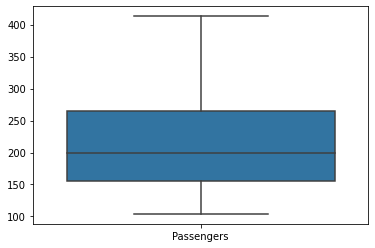

In [8]:
sns.boxplot(data =df)

<AxesSubplot:>

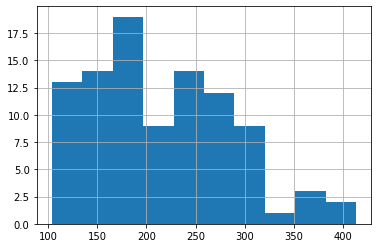

In [9]:
df.Passengers.hist()

<AxesSubplot:xlabel='Month', ylabel='Passengers'>

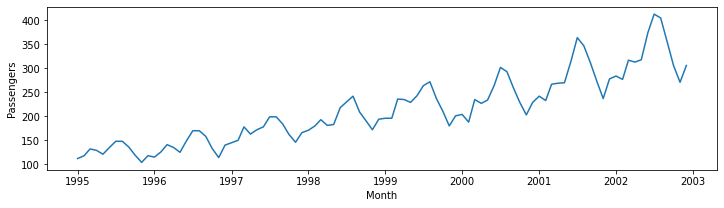

In [10]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Month",y="Passengers",data=df)

# Moving Average

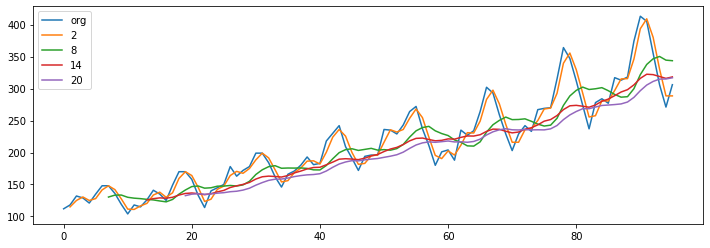

In [11]:
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
for i in range(2,24,6):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best') 

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

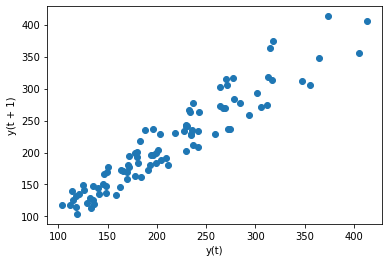

In [12]:
from pandas.plotting import lag_plot
lag_plot(df['Passengers'])

In [13]:
df['t'] = np.arange(1,97)
df['t_squared'] = df['t']**2
df["Passengers_log"] =np.log(df['Passengers'])
df.head()

,Month,Passengers,t,t_squared,Passengers_log
0,1995-01-01,112,1,1,4.718499
1,1995-02-01,118,2,4,4.770685
2,1995-03-01,132,3,9,4.882802
3,1995-04-01,129,4,16,4.859812
4,1995-05-01,121,5,25,4.795791


In [14]:
train =df.head(86)
test =df.tail(10)

In [15]:
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

In [16]:
# Linear Model
linear_model =smf.ols("Passengers~t",data =train).fit()
linear_pred = pd.Series(linear_model.predict(test['t']))
linear_rmse =np.sqrt(mean_squared_error(np.array(test['Passengers']),np.array(linear_pred)))
linear_rmse

58.64314972778256

In [17]:
# Exponential model
exp_model  =smf.ols("Passengers_log~t",data=train).fit()
exp_pred =pd.Series(exp_model.predict(test['t']))
exp_rmse =np.sqrt(mean_squared_error(np.array(test['Passengers']),np.array(exp_pred)))
exp_rmse

334.9780383662904

In [18]:
#Quadratic Model
quad_model =smf.ols("Passengers~t+t_squared",data=train).fit()
quad_pred = pd.Series(quad_model.predict(test[['t','t_squared']]))
quad_rmse =np.sqrt(mean_squared_error(np.array(test['Passengers']),np.array(quad_pred)))
quad_rmse

53.914363578529574

In [19]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_exp","rmse_quad"]),"RMSE_Values":pd.Series([linear_rmse,exp_rmse,quad_rmse,])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
2,rmse_quad,53.914364
0,rmse_linear,58.643150
1,rmse_exp,334.978038


# Using ARIMA model

In [20]:
from google.colab import files
uploaded = files.upload()

Saving Airlines+Data.xlsx to Airlines+Data (1).xlsx


In [21]:
df = pd.read_excel("Airlines+Data.xlsx",header=0,index_col=0, parse_dates=True)

In [22]:
df.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [23]:
# separate out a validation dataset
split_point = len(df) - 10
dataset, validation = df[0:split_point], df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=True)
validation.to_csv('validation.csv', header=True)

Dataset 86, Validation 10


In [24]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', index_col=0, parse_dates=True, squeeze=True)
train

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
             ... 
2001-10-01    274
2001-11-01    237
2001-12-01    278
2002-01-01    284
2002-02-01    277
Name: Passengers, Length: 86, dtype: int64

In [25]:
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [26]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

In [27]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_exp","rmse_quad","RMSE_ARIMA"]),"RMSE_Values":pd.Series([linear_rmse,exp_rmse,quad_rmse,rmse])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
3,RMSE_ARIMA,25.698158
2,rmse_quad,53.914364
0,rmse_linear,58.643150
1,rmse_exp,334.978038


# Splitting data

In [28]:
Train = df.head(147)
Test = df.tail(12) 

# Moving Average

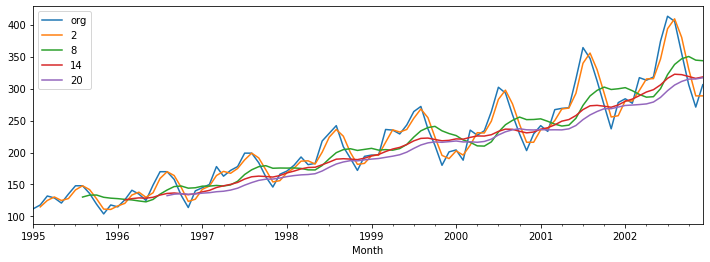

In [29]:
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
for i in range(2,24,6):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best') 

# Time series decomposition plot

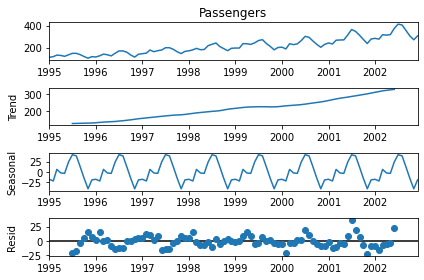

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
decompose_ts_add.plot()
plt.show() 

# ACF plots and PACF plots

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


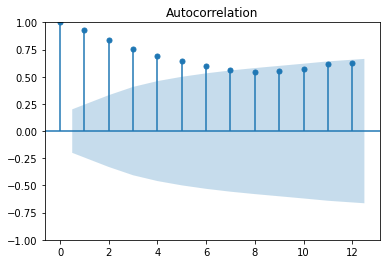

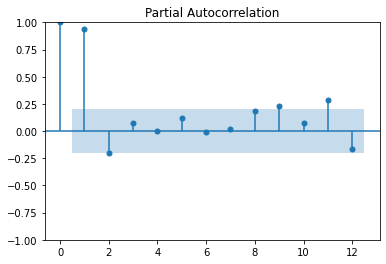

In [31]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df.Passengers,lags=12)
tsa_plots.plot_pacf(df.Passengers,lags=12)
plt.show() 

# Evaluation Metric MAPE


In [32]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)  

# Simple Exponential Method

In [33]:
Train["Passengers"] = Train["Passengers"].astype('double') 
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers)  


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


11.652581888339924

# Holt method

In [34]:
# Holt method 
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers)  

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-34-c7b6bb31309b>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)


9.843474829332123

# Holts winter exponential smoothing with additive seasonality and additive trend


In [35]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers) 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2.038558045831413

# Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [36]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


1.186249403428661

# Final Model by combining train and test

In [37]:
df["Passengers"] = df["Passengers"].astype('double')
hwe_model_mul_add = ExponentialSmoothing(df["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [38]:
#Forecasting for next 10 time periods
hwe_model_mul_add.forecast(10)   

2003-01-01    312.899424
2003-02-01    308.171306
2003-03-01    355.532782
2003-04-01    345.769814
2003-05-01    345.696096
2003-06-01    392.470733
2003-07-01    436.501361
2003-08-01    429.859243
2003-09-01    380.172872
2003-10-01    332.317301
Freq: MS, dtype: float64